<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/%ED%96%89%EC%82%AC%20%EC%B0%B8%EC%97%AC%20%EC%9D%B8%EC%9B%90%20%EC%98%88%EC%B8%A1%EC%9D%84%20%ED%86%B5%ED%95%9C%20%EC%95%88%EC%A0%84%20%EA%B4%80%EB%A6%AC%20%EC%BB%A8%EC%84%A4%ED%8C%85%20%EC%84%9C%EB%B9%84%EC%8A%A4/1004%20%ED%96%89%EC%82%AC%20%EC%9D%B8%EC%9B%90%20%EC%98%88%EC%B8%A1%20%EB%AA%A8%EB%8D%B8%20(%EA%B2%B0%EC%A0%95%20%ED%8A%B8%EB%A6%AC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install --upgrade gensim

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from gensim.utils import simple_preprocess
import nltk
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# 데이터 가져오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DAB/DAB/행사_데이터/Olympic_final_1.csv', encoding = 'cp949').iloc[:,1:]
df

,FCLTY_NM,EVENT_SDIV_NM,EVENT_NM,RENTLSPCE_BEGIN_DE,RENTLSPCE_END_DE,REQST_EVENT_NMPR_CO,EXCCLC_EVENT_NMPR_CO,ISE_ELSE_FLAG_NM,USE_DAY_CO,WEEKDAY_BEGIN,...,HOLIDAY,YEAR_END,BEGIN_AVG_WEEKDAY,END_AVG_WEEKDAY,AVG_MONTH,년도,월,계절,텍스트,유사공연_가중평균
0,우리금융아트홀,문화예술행사,2012 공동주최 기획공연 뮤지컬 페임,2012-01-01,2012-01-29,19800,21363,내부,29,6,...,1,0,4671.767123,9046.742340,8519.324324,2012년,1월,겨울,우리금융아트홀 문화예술행사 2012 공동주최 기획공연 뮤지컬 페임 2012년 1월 ...,0.000000
1,핸드볼경기장,체육행사,2012코리아배드민턴슈퍼시리즈 프리미어대회,2012-01-03,2012-01-08,7000,14957,내부,6,1,...,0,0,5544.786885,9046.742340,8519.324324,2012년,1월,겨울,핸드볼경기장 체육행사 2012코리아배드민턴슈퍼시리즈 프리미어대회 2012년 1월 겨...,0.000000
2,올림픽홀,대중공연,데미안 라이스 내한공연,2012-01-11,2012-01-11,3000,3000,내부,1,2,...,0,0,4465.204819,5102.242857,8519.324324,2012년,1월,겨울,올림픽홀 대중공연 데미안 라이스 내한공연 2012년 1월 겨울 내부,14957.000000
3,올림픽홀,대중공연,아메바이펙트 콘서트,2012-01-27,2012-01-28,8500,5700,내부,2,4,...,0,0,9870.415686,3467.288401,8519.324324,2012년,1월,겨울,올림픽홀 대중공연 아메바이펙트 콘서트 2012년 1월 겨울 내부,8801.136446
4,KSPO DOME(체조경기장),문화예술행사,2011-12 브라운아이드소울 연말 콘서트,2012-01-28,2012-01-29,20000,16509,내부,2,5,...,0,0,6682.392273,9046.742340,8519.324324,2012년,1월,겨울,KSPO DOME(체조경기장) 문화예술행사 2011-12 브라운아이드소울 연말 콘서...,9132.724512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,뮤즈라이브,문화예술행사,BoA콘서트,2023-03-11,2023-03-12,6000,4504,내부,2,5,...,0,0,6682.392273,9046.742340,7098.186916,2023년,3월,봄,뮤즈라이브 문화예술행사 BoA콘서트 2023년 3월 봄 내부,1721.505796
1334,핸드볼경기장,문화예술행사,2023 윤하 앵콜 콘서트,2023-03-11,2023-03-12,8000,9493,내부,2,5,...,0,0,6682.392273,9046.742340,7098.186916,2023년,3월,봄,핸드볼경기장 문화예술행사 2023 윤하 앵콜 콘서트 2023년 3월 봄 내부,5695.938805
1335,평화의광장,공공행사,2023 서울마라톤 겸 동아마라톤,2023-03-19,2023-03-19,10000,10000,외부,1,6,...,0,0,4671.767123,9046.742340,7098.186916,2023년,3월,봄,평화의광장 공공행사 2023 서울마라톤 겸 동아마라톤 2023년 3월 봄 외부,6640.384870
1336,KSPO DOME(체조경기장),문화예술행사,해리 스타일스 내한공연 (HARRY STYLES LIVE IN SEOUL),2023-03-20,2023-03-20,14000,15100,내부,1,0,...,0,0,4026.739130,19989.096150,7098.186916,2023년,3월,봄,KSPO DOME(체조경기장) 문화예술행사 해리 스타일스 내한공연 (HARRY ST...,11203.942690


# 예측

#### 전처리

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FCLTY_NM              1338 non-null   object 
 1   EVENT_SDIV_NM         1338 non-null   object 
 2   EVENT_NM              1338 non-null   object 
 3   RENTLSPCE_BEGIN_DE    1338 non-null   object 
 4   RENTLSPCE_END_DE      1338 non-null   object 
 5   REQST_EVENT_NMPR_CO   1338 non-null   int64  
 6   EXCCLC_EVENT_NMPR_CO  1338 non-null   int64  
 7   ISE_ELSE_FLAG_NM      1338 non-null   object 
 8   USE_DAY_CO            1338 non-null   int64  
 9   WEEKDAY_BEGIN         1338 non-null   int64  
 10  WEEKDAY_END           1338 non-null   int64  
 11  WEEKEND               1338 non-null   int64  
 12  HOLIDAY               1338 non-null   int64  
 13  YEAR_END              1338 non-null   int64  
 14  BEGIN_AVG_WEEKDAY     1338 non-null   float64
 15  END_AVG_WEEKDAY      

In [ ]:
df["FCLTY_NM"].value_counts()

올림픽홀                413
핸드볼경기장              240
KSPO DOME(체조경기장)    213
뮤즈라이브               104
우리금융아트홀              87
K-아트홀                71
평화의광장                48
88잔디마당               42
88호수수변무대             30
올림픽컨벤션센터             27
피크닉광장                15
핸드볼보조경기장             13
한얼광장                 13
기타                    9
만남의광장                 3
몽촌해자수변무대B             3
몽촌해자수변무대A             3
올림픽수영장                3
벨로드롬                  1
Name: FCLTY_NM, dtype: int64

In [ ]:
df.loc[df["FCLTY_NM"] == "올림픽홀","FCLTY_NM"] = 1
df.loc[df["FCLTY_NM"] == "핸드볼경기장","FCLTY_NM"] = 2
df.loc[df["FCLTY_NM"] == "KSPO DOME(체조경기장)","FCLTY_NM"] = 3
df.loc[df["FCLTY_NM"] == "뮤즈라이브","FCLTY_NM"] = 4
df.loc[df["FCLTY_NM"] == "우리금융아트홀","FCLTY_NM"] = 5
df.loc[df["FCLTY_NM"] == "K-아트홀","FCLTY_NM"] = 6
df.loc[df["FCLTY_NM"] == "평화의광장","FCLTY_NM"] = 7
df.loc[df["FCLTY_NM"] == "88잔디마당","FCLTY_NM"] = 8
df.loc[df["FCLTY_NM"] == "88호수수변무대","FCLTY_NM"] = 9
df.loc[df["FCLTY_NM"] == "올림픽컨벤션센터","FCLTY_NM"] = 10
df.loc[df["FCLTY_NM"] == "피크닉광장","FCLTY_NM"] = 11
df.loc[df["FCLTY_NM"] == "핸드볼보조경기장","FCLTY_NM"] = 12
df.loc[df["FCLTY_NM"] == "한얼광장","FCLTY_NM"] = 13
df.loc[df["FCLTY_NM"] == "기타","FCLTY_NM"] = 14
df.loc[df["FCLTY_NM"] == "만남의광장","FCLTY_NM"] = 15
df.loc[df["FCLTY_NM"] == "몽촌해자수변무대B","FCLTY_NM"] = 16
df.loc[df["FCLTY_NM"] == "몽촌해자수변무대A","FCLTY_NM"] = 17
df.loc[df["FCLTY_NM"] == "올림픽수영장","FCLTY_NM"] = 18
df.loc[df["FCLTY_NM"] == "벨로드롬","FCLTY_NM"] = 19

In [ ]:
df.loc[df["EVENT_SDIV_NM"] == "문화예술행사","EVENT_SDIV_NM"] = 1
df.loc[df["EVENT_SDIV_NM"] == "대중공연","EVENT_SDIV_NM"] = 2
df.loc[df["EVENT_SDIV_NM"] == "체육행사","EVENT_SDIV_NM"] = 3
df.loc[df["EVENT_SDIV_NM"] == "공공행사","EVENT_SDIV_NM"] = 4
df.loc[df["EVENT_SDIV_NM"] == "순수예술공연","EVENT_SDIV_NM"] = 5

- 12월, 1월, 2월: 겨울 (1)
- 3월, 4월, 5월: 봄 (2)
- 6월, 7월, 8월: 여름 (3)
- 9월, 10월, 11월: 가을 (4)

In [ ]:
df["계절"] = 0

In [ ]:
# 년도에서 숫자만 출력
df['년도'] = df['년도'].str.extract(r'(\d+)')

In [ ]:
# 월에서 숫자만 출력
df['월'] = df['월'].str.extract(r'(\d+)')

In [ ]:
df = df.astype({'년도':'int','월':'int'})

In [ ]:
df.loc[(df["월"] == 12) | (df["월"] == 1) | (df["월"] == 2),"계절"] = 1
df.loc[(df["월"] == 3) | (df["월"] == 4) | (df["월"] == 5),"계절"] = 2
df.loc[(df["월"] == 6) | (df["월"] == 7) | (df["월"] == 8),"계절"] = 3
df.loc[(df["월"] == 9) | (df["월"] == 10) | (df["월"] == 11),"계절"] = 4

In [ ]:
df["계절"] = df["계절"].astype('category')
df["FCLTY_NM"] = df["FCLTY_NM"].astype('category')
df["EVENT_SDIV_NM"] = df["EVENT_SDIV_NM"].astype('category')
df["ISE_ELSE_FLAG_NM"] = df["ISE_ELSE_FLAG_NM"].astype('category')
df["WEEKDAY_BEGIN"] = df["WEEKDAY_BEGIN"].astype('category')
df["WEEKDAY_END"] = df["WEEKDAY_END"].astype('category')
df["WEEKEND"] = df["WEEKEND"].astype('category')
df["HOLIDAY"] = df["HOLIDAY"].astype('category')
df["YEAR_END"] = df["YEAR_END"].astype('category')
df.년도 = df.년도.astype('category')

In [ ]:
df.head()

,FCLTY_NM,EVENT_SDIV_NM,EVENT_NM,RENTLSPCE_BEGIN_DE,RENTLSPCE_END_DE,REQST_EVENT_NMPR_CO,EXCCLC_EVENT_NMPR_CO,ISE_ELSE_FLAG_NM,USE_DAY_CO,WEEKDAY_BEGIN,...,HOLIDAY,YEAR_END,BEGIN_AVG_WEEKDAY,END_AVG_WEEKDAY,AVG_MONTH,년도,월,계절,텍스트,유사공연_가중평균
0,5,1,2012 공동주최 기획공연 뮤지컬 페임,2012-01-01,2012-01-29,19800,21363,내부,29,6,...,1,0,4671.767123,9046.742340,8519.324324,2012,1,1,우리금융아트홀 문화예술행사 2012 공동주최 기획공연 뮤지컬 페임 2012년 1월 ...,0.000000
1,2,3,2012코리아배드민턴슈퍼시리즈 프리미어대회,2012-01-03,2012-01-08,7000,14957,내부,6,1,...,0,0,5544.786885,9046.742340,8519.324324,2012,1,1,핸드볼경기장 체육행사 2012코리아배드민턴슈퍼시리즈 프리미어대회 2012년 1월 겨...,0.000000
2,1,2,데미안 라이스 내한공연,2012-01-11,2012-01-11,3000,3000,내부,1,2,...,0,0,4465.204819,5102.242857,8519.324324,2012,1,1,올림픽홀 대중공연 데미안 라이스 내한공연 2012년 1월 겨울 내부,14957.000000
3,1,2,아메바이펙트 콘서트,2012-01-27,2012-01-28,8500,5700,내부,2,4,...,0,0,9870.415686,3467.288401,8519.324324,2012,1,1,올림픽홀 대중공연 아메바이펙트 콘서트 2012년 1월 겨울 내부,8801.136446
4,3,1,2011-12 브라운아이드소울 연말 콘서트,2012-01-28,2012-01-29,20000,16509,내부,2,5,...,0,0,6682.392273,9046.742340,8519.324324,2012,1,1,KSPO DOME(체조경기장) 문화예술행사 2011-12 브라운아이드소울 연말 콘서...,9132.724512


#### Dataset 나누기

In [ ]:
# df_pred
X_1 = df.iloc[:,[0,1,5,8,21]].values
y_1 = df["EXCCLC_EVENT_NMPR_CO"].values

In [ ]:
# train & test set 분할
from sklearn.model_selection import train_test_split

# 8:2로 test train set 나누기
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size = 0.2, shuffle=True)

# train_set 한 번 더 나누기
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1,y_train1, test_size = 0.2, shuffle=True)

In [ ]:
# df_pred
X_2 = df.iloc[:,[0,5,8,12,15,17,18,19,21]].values
y_2 = df["EXCCLC_EVENT_NMPR_CO"].values

# 8:2로 test train set 나누기
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size = 0.2, shuffle=True)

# train_set 한 번 더 나누기
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2,y_train2, test_size = 0.2, shuffle=True)

#### Model 2 (회귀분석)
- 변수: 공연장소, 공연유형, 신청인원, 사용일수, vector3_col
- vector3_col: vector3 함수를 이용해 도출한 유사공연의 정산인원

In [ ]:
df_train1 = pd.concat([pd.DataFrame(X_train1),pd.DataFrame(y_train1)], axis=1)
df_train1.columns = ["FCLTY_NM","EVENT_SDIV_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","유사공연_가중평균","EXCCLC_EVENT_NMPR_CO"];
df_train1

,FCLTY_NM,EVENT_SDIV_NM,REQST_EVENT_NMPR_CO,USE_DAY_CO,유사공연_가중평균,EXCCLC_EVENT_NMPR_CO
0,3.0,1.0,40100.0,3.0,27484.323360,43969
1,10.0,2.0,500.0,2.0,1717.909165,847
2,1.0,2.0,3000.0,1.0,2989.985835,2450
3,1.0,1.0,5700.0,3.0,1924.934493,4653
4,7.0,4.0,1000.0,3.0,1157.900552,4200
...,...,...,...,...,...,...
851,3.0,1.0,20000.0,4.0,7670.615677,3000
852,1.0,1.0,6500.0,1.0,4244.822668,4188
853,2.0,1.0,6500.0,1.0,5082.223808,5660
854,2.0,3.0,700.0,1.0,1094.520872,1500


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
model_reg1 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO ~ C(FCLTY_NM)+C(EVENT_SDIV_NM)+REQST_EVENT_NMPR_CO+USE_DAY_CO+유사공연_가중평균',data= df_train1).fit()
model_reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.684
Model:                              OLS   Adj. R-squared:                  0.675
Method:                   Least Squares   F-statistic:                     71.88
Date:                  Wed, 04 Oct 2023   Prob (F-statistic):          3.09e-188
Time:                          12:27:13   Log-Likelihood:                -8593.7
No. Observations:                   856   AIC:                         1.724e+04
Df Residuals:                       830   BIC:                         1.736e+04
Df Model:                            25                                         
Covariance Type:              nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2171.4091    572.681      3.792      0.000    1047.336    3295.482
C(FCLTY_NM)[T.2.0]       2339.7495    739.724      3.163      0.002     887.800    3791.699
C(FCLTY_NM)[T.3.0]       1.116e+04    783.587     14.248      0.000    9626.846    1.27e+04
C(FCLTY_NM)[T.4.0]      -2624.5899    851.572     -3.082      0.002   -4296.078    -953.102
C(FCLTY_NM)[T.5.0]      -1690.3786    884.239     -1.912      0.056   -3425.987      45.230
C(FCLTY_NM)[T.6.0]      -2565.3841    938.962     -2.732      0.006   -4408.404    -722.364
C(FCLTY_NM)[T.7.0]       3871.1204   1865.428      2.075      0.038     209.609    7532.631
C(FCLTY_NM)[T.8.0]       7300.3851   1293.290      5.645      0.000    4761.881    9838.889
C(FCLTY_NM)[T.9.0]      -1093.7089   1369.455     -0.799      0.425   -3781.712    1594.294
C(FCLTY_NM)[T.10.0]     -5549.6466   1446.618     -3.836      0.000   -8389.106   -2710.187
C(FCLTY_NM)[T.11.0]      2474.5355   2375.936      1.041      0.298   -2189.014    7138.085
C(FCLTY_NM)[T.12.0]      1610.1238   2318.505      0.694      0.488   -2940.699    6160.947
C(FCLTY_NM)[T.13.0]      7612.2825   2236.519      3.404      0.001    3222.385     1.2e+04
C(FCLTY_NM)[T.14.0]      2435.9616   2554.251      0.954      0.341   -2577.590    7449.513
C(FCLTY_NM)[T.15.0]      6652.1898   3624.498      1.835      0.067    -462.070    1.38e+04
C(FCLTY_NM)[T.16.0]      1971.0563   5853.140      0.337      0.736   -9517.640    1.35e+04
C(FCLTY_NM)[T.17.0]      1416.3813   5854.521      0.242      0.809   -1.01e+04    1.29e+04
C(FCLTY_NM)[T.18.0]      3021.9196   4100.535      0.737      0.461   -5026.718    1.11e+04
C(FCLTY_NM)[T.19.0]      1474.9234   5715.438      0.258      0.796   -9743.487    1.27e+04
C(EVENT_SDIV_NM)[T.2.0]   106.1389    621.045      0.171      0.864   -1112.864    1325.142
C(EVENT_SDIV_NM)[T.3.0] -4202.9333    871.669     -4.822      0.000   -5913.869   -2491.998
C(EVENT_SDIV_NM)[T.4.0] -5423.7388   1496.386     -3.625      0.000   -8360.884   -2486.594
C(EVENT_SDIV_NM)[T.5.0] -2369.0426   1874.826     -1.264      0.207   -6049.000    1310.915
REQST_EVENT_NMPR_CO         0.1605      0.008     21.213      0.000       0.146       0.175
USE_DAY_CO                394.2418     37.227     10.590      0.000     321.171     467.313
유사공연_가중평균                   0.1225      0.033      3.689      0.000       0.057       0.188
==============================================================================
Omnibus:                      544.236   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21607.737
Skew:                           2.284   Prob(JB):                         0.00
Kurtosis:                      27.186   Cond. No.                     1.01e+0

In [ ]:
x_cols = ["FCLTY_NM","EVENT_SDIV_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","유사공연_가중평균"]

In [ ]:
# 회귀분석을 통해 인원을 예측하는 함수

def makeprediction2(index,df):
  result = model_reg1.predict(df.loc[index,x_cols])
  return int(result)

In [ ]:
model_reg1.predict(df[x_cols])

0       15091.622682
1        3797.063132
2        4985.851125
3        5508.505829
4       18453.451025
            ...     
1333     1509.133937
1334     7281.409398
1335     3431.486079
1336    17350.082315
1337     1384.319529
Length: 1338, dtype: float64

In [ ]:
score2_df = pd.DataFrame([df["EXCCLC_EVENT_NMPR_CO"], model_reg1.predict(df[x_cols])],index=["EXCCLC_EVENT_NMPR_CO","makeprediction2"]).transpose()
score2_df

,EXCCLC_EVENT_NMPR_CO,makeprediction2
0,21363.0,15091.622682
1,14957.0,3797.063132
2,3000.0,4985.851125
3,5700.0,5508.505829
4,16509.0,18453.451025
...,...,...
1333,4504.0,1509.133937
1334,9493.0,7281.409398
1335,10000.0,3431.486079
1336,15100.0,17350.082315


In [ ]:
from matplotlib import pyplot as plt

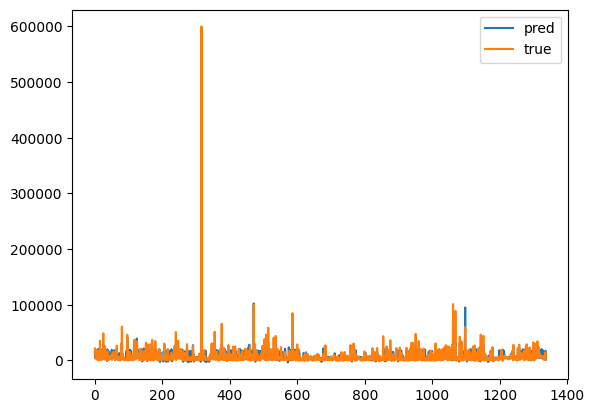

In [ ]:
plt.plot(np.array(model_reg1.predict(df[x_cols])),label = "pred")
plt.plot(np.array(df["EXCCLC_EVENT_NMPR_CO"]),label = "true")
plt.legend()
plt.show()

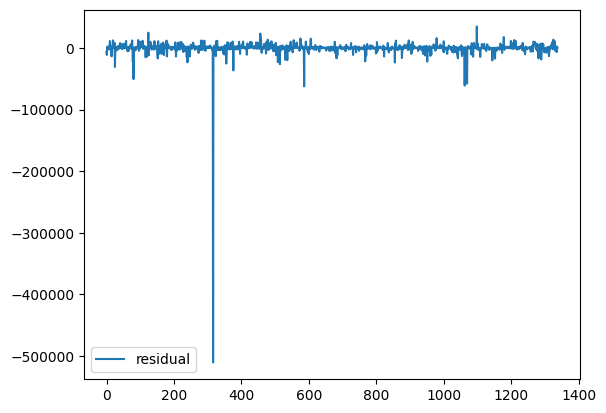

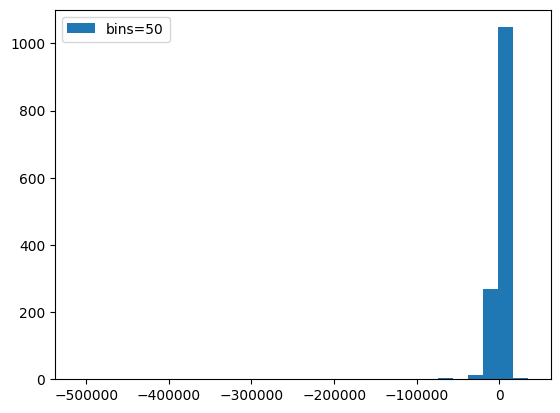

In [ ]:
plt.plot(np.array(model_reg1.predict(df[x_cols])) - np.array(df["EXCCLC_EVENT_NMPR_CO"]),label = "residual")
plt.legend()
plt.show()

residual = np.array(model_reg1.predict(df[x_cols])) - np.array(df["EXCCLC_EVENT_NMPR_CO"])
plt.hist(residual, bins=30, label='bins=50')
plt.legend()
plt.show()

In [ ]:
# MSE
from sklearn.metrics import mean_squared_error

mean_squared_error(df["EXCCLC_EVENT_NMPR_CO"], model_reg1.predict(df[x_cols]))

230771803.24126086

#### Model 2_1 (회귀분석)
- 변수: FCLTY_NM_cluster, 공연유형, 신청인원, 사용일수,vector3_col,
- 공연장소별 정산인원 평균을 내서 군집 4개로 만들고자 함.

공연장소별 정산인원 평균- 3개정도로 줄이기 > makeprediction2 적용해보기

- 공연장소  올림픽홀 (1), 핸드볼경기장 (2), KSPO DOME(체조경기장) (3), 뮤즈라이브 (4), 우리금융아트홀 (5),  K-아트홀 (6), 평화의광장 (7), 88잔디마당 (8), 88호수수변무대 (9), 올림픽컨벤션센터 (10), 피크닉광장 (11), 핸드볼보조경기장 (12), 한얼광장 (13), 기타 (14), 만남의광장 (15), 몽촌해자수변무대B (16), 몽촌해자수변무대A (17), 올림픽수영장 (18), 벨로드롬 (19)

In [ ]:
df_train1.groupby(['FCLTY_NM'], as_index=False).mean()["EXCCLC_EVENT_NMPR_CO"].sort_values(ascending = False)

# 10000명, 5000명, 1000명을 기준선으로 적용
# 16에 대한 평균값이 이상하게 크게 나와서 직접 계산하여 적용
# 1 (2,7,12)/ 2 (6,4,14,1)/ 3 (0,8,17,9,13,11,15,16,5)/ 4 (10,3,18)

2     19328.056452
7     14011.260870
12    11873.428571
6      9626.066667
14     6666.666667
4      6416.767857
1      5539.729560
0      4429.852399
15     4000.000000
8      3209.100000
9      2600.555556
17     2500.000000
13     2175.000000
11     1004.285714
5       815.466667
16      600.000000
3       506.428571
10      437.000000
18       30.000000
Name: EXCCLC_EVENT_NMPR_CO, dtype: float64

In [ ]:
df_new = df_train1.copy()

# 1~4 군집 중 어디에 속하는 지
df_new["FCLTY_NM_cluster"] = 0
df_new.loc[(df_new["FCLTY_NM"]== 2) | (df_new["FCLTY_NM"]== 7) | (df_new["FCLTY_NM"]== 12), "FCLTY_NM_cluster"] = 1
df_new.loc[(df_new["FCLTY_NM"]== 6) | (df_new["FCLTY_NM"]== 4) | (df_new["FCLTY_NM"]== 14) | (df_new["FCLTY_NM"]== 1),"FCLTY_NM_cluster"] = 2
df_new.loc[(df_new["FCLTY_NM"]== 0) | (df_new["FCLTY_NM"]== 8) | (df_new["FCLTY_NM"]== 17) | (df_new["FCLTY_NM"]== 9) | (df_new["FCLTY_NM"]== 13) | (df_new["FCLTY_NM"]== 11) | (df_new["FCLTY_NM"]== 15)| (df_new["FCLTY_NM"]== 16) | (df_new["FCLTY_NM"]== 5),"FCLTY_NM_cluster"] = 3
df_new.loc[(df_new["FCLTY_NM"]== 10) | (df_new["FCLTY_NM"]== 3) | (df_new["FCLTY_NM"]== 18),"FCLTY_NM_cluster"] = 4
df_new

,FCLTY_NM,EVENT_SDIV_NM,REQST_EVENT_NMPR_CO,USE_DAY_CO,유사공연_가중평균,EXCCLC_EVENT_NMPR_CO,FCLTY_NM_cluster
0,3.0,1.0,40100.0,3.0,27484.323360,43969,4
1,10.0,2.0,500.0,2.0,1717.909165,847,4
2,1.0,2.0,3000.0,1.0,2989.985835,2450,2
3,1.0,1.0,5700.0,3.0,1924.934493,4653,2
4,7.0,4.0,1000.0,3.0,1157.900552,4200,1
...,...,...,...,...,...,...,...
851,3.0,1.0,20000.0,4.0,7670.615677,3000,4
852,1.0,1.0,6500.0,1.0,4244.822668,4188,2
853,2.0,1.0,6500.0,1.0,5082.223808,5660,1
854,2.0,3.0,700.0,1.0,1094.520872,1500,1


In [ ]:
model_reg1_new = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO~ C(FCLTY_NM_cluster)+C(EVENT_SDIV_NM)+REQST_EVENT_NMPR_CO+USE_DAY_CO+유사공연_가중평균',data= df_new).fit()
model_reg1_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.619
Model:                              OLS   Adj. R-squared:                  0.615
Method:                   Least Squares   F-statistic:                     124.9
Date:                  Wed, 04 Oct 2023   Prob (F-statistic):          1.22e-168
Time:                          12:28:50   Log-Likelihood:                -8673.2
No. Observations:                   856   AIC:                         1.737e+04
Df Residuals:                       844   BIC:                         1.743e+04
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 3647.8339   6194.230      0.589      0.556   -8510.068    1.58e+04
C(FCLTY_NM_cluster)[T.1]   467.0540   6173.939      0.076      0.940   -1.17e+04    1.26e+04
C(FCLTY_NM_cluster)[T.2] -1486.3695   6202.558     -0.240      0.811   -1.37e+04    1.07e+04
C(FCLTY_NM_cluster)[T.3]    -9.9436   6215.216     -0.002      0.999   -1.22e+04    1.22e+04
C(FCLTY_NM_cluster)[T.4]  6816.3316   6214.256      1.097      0.273   -5380.878     1.9e+04
C(EVENT_SDIV_NM)[T.2.0]  -1535.7097    542.284     -2.832      0.005   -2600.093    -471.326
C(EVENT_SDIV_NM)[T.3.0]  -4232.1383    903.529     -4.684      0.000   -6005.565   -2458.712
C(EVENT_SDIV_NM)[T.4.0]  -4309.6645    841.097     -5.124      0.000   -5960.551   -2658.778
C(EVENT_SDIV_NM)[T.5.0]  -6548.0367   1913.862     -3.421      0.001   -1.03e+04   -2791.549
REQST_EVENT_NMPR_CO          0.1650      0.008     20.422      0.000       0.149       0.181
USE_DAY_CO                 273.7968     37.207      7.359      0.000     200.767     346.826
유사공연_가중평균                    0.2192      0.035      6.317      0.000       0.151       0.287
==============================================================================
Omnibus:                      499.659   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14699.838
Skew:                           2.102   Prob(JB):                         0.00
Kurtosis:                      22.861   Cond. No.                     2.04e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model 2_2 (회귀분석)
- 변수: 공연장소, 신청인원, 사용일수, 휴일, END_AVG_WEEKDAY, 년도, 월, 계절, vector3_col

In [ ]:
df_train2 = pd.concat([pd.DataFrame(X_train2),pd.DataFrame(y_train2)], axis=1)
df_train2.columns = ["FCLTY_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","HOLIDAY","END_AVG_WEEKDAY","년도","월","계절","유사공연_가중평균","EXCCLC_EVENT_NMPR_CO"];
df_train2

,FCLTY_NM,REQST_EVENT_NMPR_CO,USE_DAY_CO,HOLIDAY,END_AVG_WEEKDAY,년도,월,계절,유사공연_가중평균,EXCCLC_EVENT_NMPR_CO
0,8.0,20000.0,2.0,0.0,9046.742340,2019.0,10.0,4.0,23660.961910,19029
1,1.0,4000.0,1.0,0.0,3467.288401,2015.0,3.0,2.0,3191.958042,2270
2,10.0,300.0,1.0,0.0,3467.288401,2013.0,11.0,4.0,6745.359878,420
3,8.0,8000.0,1.0,1.0,3467.288401,2015.0,6.0,3.0,10368.234770,2443
4,2.0,5000.0,2.0,0.0,9046.742340,2016.0,11.0,4.0,3822.339701,2534
...,...,...,...,...,...,...,...,...,...,...
851,2.0,900.0,2.0,0.0,9046.742340,2022.0,8.0,3.0,5411.167537,900
852,1.0,200.0,1.0,0.0,3467.288401,2014.0,3.0,2.0,2759.964657,201
853,2.0,6000.0,2.0,0.0,3467.288401,2014.0,5.0,2.0,6183.428886,6763
854,2.0,1800.0,1.0,0.0,3467.288401,2014.0,12.0,1.0,7445.702564,1433


In [ ]:
model_reg2 = smf.ols(formula= 'EXCCLC_EVENT_NMPR_CO ~ C(FCLTY_NM)+REQST_EVENT_NMPR_CO+USE_DAY_CO+C(HOLIDAY)+END_AVG_WEEKDAY+C(년도)+C(월)+C(계절)+유사공연_가중평균',data= df_train2).fit()
model_reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     EXCCLC_EVENT_NMPR_CO   R-squared:                       0.759
Model:                              OLS   Adj. R-squared:                  0.745
Method:                   Least Squares   F-statistic:                     56.64
Date:                  Wed, 04 Oct 2023   Prob (F-statistic):          1.55e-217
Time:                          12:29:08   Log-Likelihood:                -8425.4
No. Observations:                   856   AIC:                         1.694e+04
Df Residuals:                       810   BIC:                         1.716e+04
Df Model:                            45                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1230.6661    980.972     -1.255      0.210   -3156.214     694.882
C(FCLTY_NM)[T.2.0]    296.9168    493.205      0.602      0.547    -671.193    1265.027
C(FCLTY_NM)[T.3.0]   6773.9124    608.760     11.127      0.000    5578.980    7968.845
C(FCLTY_NM)[T.4.0]  -1240.5328    684.880     -1.811      0.070   -2584.883     103.817
C(FCLTY_NM)[T.5.0]    -58.1778    739.263     -0.079      0.937   -1509.275    1392.919
C(FCLTY_NM)[T.6.0]  -1870.9959    773.300     -2.419      0.016   -3388.903    -353.088
C(FCLTY_NM)[T.7.0]    506.9740    994.952      0.510      0.611   -1446.015    2459.963
C(FCLTY_NM)[T.8.0]   3029.4400   1035.478      2.926      0.004     996.903    5061.977
C(FCLTY_NM)[T.9.0]   -350.4438   1071.882     -0.327      0.744   -2454.437    1753.549
C(FCLTY_NM)[T.10.0] -3731.7120   1378.123     -2.708      0.007   -6436.826   -1026.598
C(FCLTY_NM)[T.11.0]  -767.3317   1496.114     -0.513      0.608   -3704.050    2169.387
C(FCLTY_NM)[T.12.0]  -945.2918   1825.447     -0.518      0.605   -4528.457    2637.873
C(FCLTY_NM)[T.13.0]  5307.5888   1677.847      3.163      0.002    2014.148    8601.030
C(FCLTY_NM)[T.14.0] -2461.0871   1996.021     -1.233      0.218   -6379.071    1456.897
C(FCLTY_NM)[T.15.0]  3669.5590   3358.673      1.093      0.275   -2923.170    1.03e+04
C(FCLTY_NM)[T.16.0]   375.3261   4752.318      0.079      0.937   -8952.985    9703.637
C(FCLTY_NM)[T.17.0]  2.992e+04   4862.135      6.154      0.000    2.04e+04    3.95e+04
C(FCLTY_NM)[T.18.0]   144.7085   3398.515      0.043      0.966   -6526.227    6815.644
C(FCLTY_NM)[T.19.0]   276.5569   4767.182      0.058      0.954   -9080.930    9634.044
C(HOLIDAY)[T.1.0]    -129.1100    656.979     -0.197      0.844   -1418.691    1160.471
C(년도)[T.2013.0]       198.3270    786.822      0.252      0.801   -1346.124    1742.778
C(년도)[T.2014.0]       857.1558    799.486      1.072      0.284    -712.153    2426.465
C(년도)[T.2015.0]       508.5840    743.143      0.684      0.494    -950.130    1967.298
C(년도)[T.2016.0]       944.5450    750.429      1.259      0.209    -528.469    2417.559
C(년도)[T.2017.0]      1685.0948    814.756      2.068      0.039      85.813    3284.376
C(년도)[T.2018.0]      1507.3121    708.541      2.127      0.034     116.518    2898.106
C(년도)[T.2019.0]      2140.9461    721.335      2.968      0.003     725.039    3556.853
C(년도)[T.2020.0]      1684.4418   1474.796      1.142      0.254   -1210.431    4579.315
C(년도)[T.2021.0]      -387.0505   1048.289     -0.369      0.712   -2444.734    1670.634
C(년도)[T.2022.0]       709.2528    818.115      0.867      0.386    -896.623    2315.128
C(년도)[T.2023.0]      -488.8266   1571.761     -0.311      0.756   -3574.032    2596.379
C(월)[T.2.0]          -307.0308    930.916     -0.330      0.742   -21

In [ ]:
x_cols = ["FCLTY_NM","REQST_EVENT_NMPR_CO","USE_DAY_CO","HOLIDAY","END_AVG_WEEKDAY","년도","월","계절","유사공연_가중평균"]

In [ ]:
# 회귀분석을 통해 인원을 예측하는 함수

def makeprediction2_1(index,df):
  result = model_reg2.predict(df.loc[index,x_cols])
  return int(result)

In [ ]:
model_reg2.predict(df[x_cols])

score2_2_df = pd.DataFrame([df["EXCCLC_EVENT_NMPR_CO"], model_reg2.predict(df[x_cols])],index=["EXCCLC_EVENT_NMPR_CO","makeprediction2"]).transpose()
score2_2_df


,EXCCLC_EVENT_NMPR_CO,makeprediction2
0,21363.0,12078.062192
1,14957.0,4801.151265
2,3000.0,1853.819074
3,5700.0,4152.824855
4,16509.0,17880.032902
...,...,...
1333,4504.0,2353.165590
1334,9493.0,5021.122633
1335,10000.0,6210.592854
1336,15100.0,16891.178967


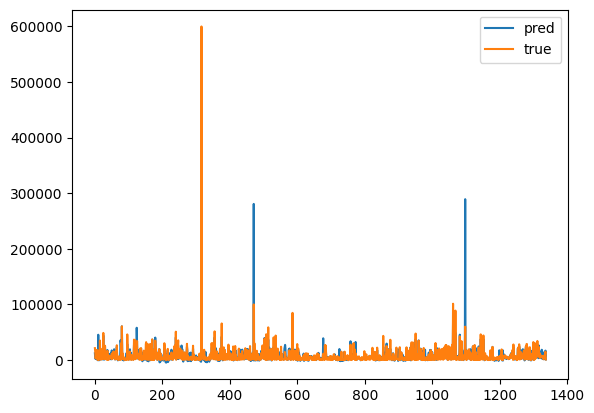

In [ ]:
plt.plot(np.array(model_reg2.predict(df[x_cols])),label = "pred")
plt.plot(np.array(df["EXCCLC_EVENT_NMPR_CO"]),label = "true")
plt.legend()
plt.show()

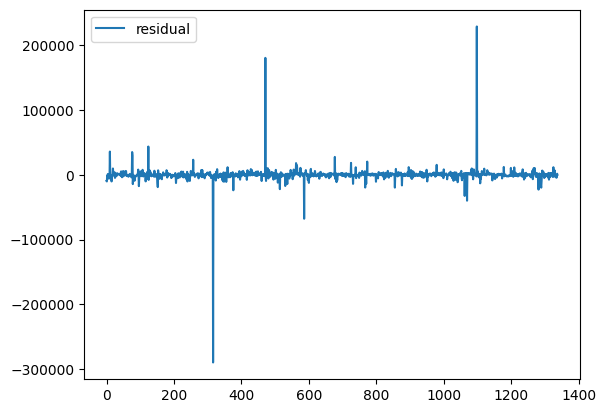

In [ ]:
plt.plot(np.array(model_reg2.predict(df[x_cols])-np.array(df["EXCCLC_EVENT_NMPR_CO"])),label = "residual")
plt.legend()
plt.show()

In [ ]:
mean_squared_error(df["EXCCLC_EVENT_NMPR_CO"], model_reg2.predict(df[x_cols]))

152323639.96725598

#### Model 3_1 (ANN)
- 변수:  공연장소, 공연유형, 신청인원, 사용일수, vector3_col

Buiding ANN

In [ ]:
import tensorflow as tf

In [ ]:
ann1 = tf.keras.models.Sequential()

In [ ]:
ann1.add(tf.keras.layers.Dense(units=6, activation='relu'))

In [ ]:
ann1.add(tf.keras.layers.Dense(units=4, activation='relu'))

In [ ]:
ann1.add(tf.keras.layers.Dense(units=1))

Training the ANN

In [ ]:
ann1.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['MeanSquaredLogarithmicError'])

In [ ]:
model_ann1 = ann1.fit(X_train1, y_train1, batch_size = 64, epochs = 30,validation_data=(X_val1, y_val1), shuffle=True)

Epoch 1/30
14/14 [==============================] - 3s 76ms/step - loss: 119552432.0000 - mean_squared_logarithmic_error: 34.8870 - val_loss: 1505715328.0000 - val_mean_squared_logarithmic_error: 29.4185
Epoch 2/30
14/14 [==============================] - 0s 7ms/step - loss: 111133440.0000 - mean_squared_logarithmic_error: 23.9544 - val_loss: 1471985664.0000 - val_mean_squared_logarithmic_error: 11.9426
Epoch 3/30
14/14 [==============================] - 0s 7ms/step - loss: 104348088.0000 - mean_squared_logarithmic_error: 7.0587 - val_loss: 1440472576.0000 - val_mean_squared_logarithmic_error: 4.3462
Epoch 4/30
14/14 [==============================] - 0s 8ms/step - loss: 98155576.0000 - mean_squared_logarithmic_error: 3.6256 - val_loss: 1410221824.0000 - val_mean_squared_logarithmic_error: 3.0340
Epoch 5/30
14/14 [==============================] - 0s 8ms/step - loss: 92070016.0000 - mean_squared_logarithmic_error: 2.6228 - val_loss: 1385803264.0000 - val_mean_squared_logarithmic_error:

In [ ]:
# test set으로 예측 평가

y_pred1 = ann1.predict(X_val1)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred1.reshape(len(y_pred1),1), y_val1.reshape(len(y_val1),1)),1))

7/7 [==============================] - 3s 503ms/step
[[1.74e+02 1.50e+02]
 [1.66e+03 2.16e+03]
 [1.68e+02 1.48e+02]
 [8.11e+03 2.65e+04]
 [2.06e+03 2.81e+03]
 [1.42e+04 2.57e+04]
 [1.69e+04 3.60e+04]
 [8.91e+02 1.35e+02]
 [1.11e+03 8.00e+02]
 [2.49e+03 3.77e+03]
 [3.92e+02 1.00e+02]
 [1.13e+04 1.19e+04]
 [1.59e+04 1.28e+04]
 [1.50e+03 2.56e+02]
 [2.12e+03 3.00e+02]
 [7.01e+03 9.50e+01]
 [8.48e+03 8.98e+03]
 [1.81e+02 2.06e+02]
 [1.38e+03 1.05e+03]
 [3.67e+03 4.59e+03]
 [1.03e+03 1.80e+03]
 [1.39e+03 8.90e+02]
 [1.78e+04 1.96e+04]
 [2.21e+02 2.35e+02]
 [1.06e+03 1.00e+03]
 [3.10e+04 4.25e+04]
 [2.20e+03 1.80e+03]
 [6.55e+03 4.79e+03]
 [2.37e+03 3.00e+03]
 [2.61e+03 4.44e+03]
 [4.37e+03 3.72e+03]
 [2.44e+03 7.00e+01]
 [9.44e+02 2.35e+02]
 [1.11e+04 1.54e+04]
 [4.82e+03 2.06e+03]
 [2.46e+03 4.09e+03]
 [3.01e+02 8.70e+02]
 [2.75e+03 3.96e+03]
 [6.26e+02 1.61e+03]
 [5.18e+03 4.35e+03]
 [1.11e+03 1.00e+03]
 [1.74e+03 2.55e+03]
 [2.82e+03 2.44e+03]
 [8.13e+02 2.00e+02]
 [2.41e+03 2.69e+03]
 [

In [ ]:
import sklearn.metrics

evs_no=sklearn.metrics.explained_variance_score(y_val1,ann1.predict(X_val1))
mse_no=sklearn.metrics.mean_squared_error(y_val1,ann1.predict(X_val1))
r2_no=sklearn.metrics.r2_score(y_val1,ann1.predict(X_val1))

7/7 [==============================] - 0s 2ms/step


In [ ]:
print('Explained Variance Score:',evs_no)
print('Mean Square Error       :',mse_no)
print('R2 Score                :',r2_no)

Explained Variance Score: 0.2668813765574457
Mean Square Error       : 1308298008.0172217
R2 Score                : 0.25609333919056765


dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])


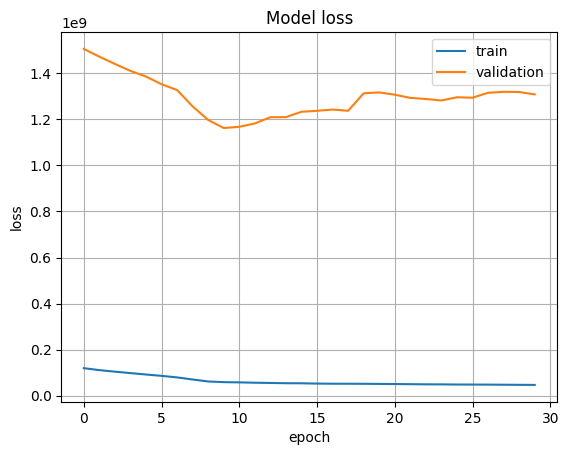

In [ ]:
# list all data in history
print(model_ann1.history.keys())
plt.plot(model_ann1.history['loss'])
plt.plot(model_ann1.history['val_loss'])
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

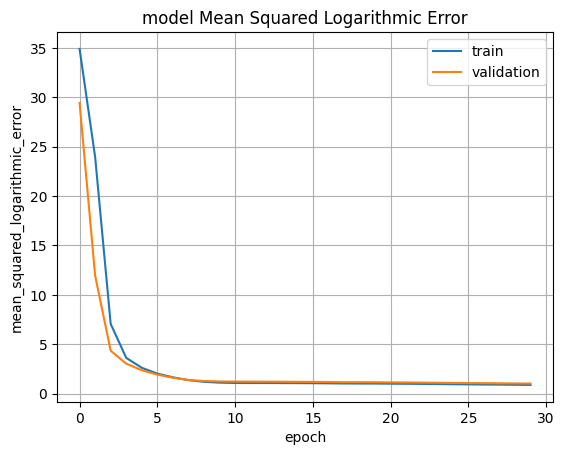

In [ ]:
# summarize history for loss
plt.plot(model_ann1.history['mean_squared_logarithmic_error'])
plt.plot(model_ann1.history['val_mean_squared_logarithmic_error'])
plt.grid()
plt.title('model Mean Squared Logarithmic Error')
plt.ylabel('mean_squared_logarithmic_error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
score3_df = pd.concat([pd.DataFrame(y_pred1),pd.DataFrame(y_val1)], axis=1)
score3_df.columns = ["validation","predict"]
score3_df

,validation,predict
0,173.684891,150
1,1662.915649,2162
2,167.561035,148
3,8113.064941,26545
4,2056.288574,2810
...,...,...
209,5841.551758,6760
210,4502.893066,6657
211,16723.000000,34117
212,6743.603516,7449


#### Model 3_2 (ANN)
- 변수: 공연장소, 신청인원, 사용일수, 휴일, END_AVG_WEEKDAY, 년도, 월, 계절, vector3_col

In [ ]:
ann2 = tf.keras.models.Sequential()
ann2.add(tf.keras.layers.Dense(units=10, activation='relu'))
ann2.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann2.add(tf.keras.layers.Dense(units=1))

Training the ANN

In [ ]:
ann2.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['MeanSquaredLogarithmicError'])
model_ann2 = ann2.fit(X_train2, y_train2, batch_size = 16, epochs = 25,validation_data=(X_val2, y_val2), shuffle=True)

Epoch 1/25
54/54 [==============================] - 6s 32ms/step - loss: 311148096.0000 - mean_squared_logarithmic_error: 65.7986 - val_loss: 4024774400.0000 - val_mean_squared_logarithmic_error: 66.1644
Epoch 2/25
54/54 [==============================] - 0s 3ms/step - loss: 231369200.0000 - mean_squared_logarithmic_error: 65.7986 - val_loss: 3283377920.0000 - val_mean_squared_logarithmic_error: 66.1644
Epoch 3/25
54/54 [==============================] - 0s 3ms/step - loss: 179516352.0000 - mean_squared_logarithmic_error: 65.7986 - val_loss: 2706560512.0000 - val_mean_squared_logarithmic_error: 66.1644
Epoch 4/25
54/54 [==============================] - 0s 3ms/step - loss: 145975376.0000 - mean_squared_logarithmic_error: 53.2892 - val_loss: 2340900864.0000 - val_mean_squared_logarithmic_error: 24.8373
Epoch 5/25
54/54 [==============================] - 3s 50ms/step - loss: 134467424.0000 - mean_squared_logarithmic_error: 15.0285 - val_loss: 2135219712.0000 - val_mean_squared_logarithmi

test set으로 예측 평가

In [ ]:
y_pred2 = ann2.predict(X_val2)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred2.reshape(len(y_val2),1), y_val2.reshape(len(y_val2),1)),1))

7/7 [==============================] - 0s 2ms/step
[[ 8.79e+01  3.18e+02]
 [ 8.55e+03  5.23e+03]
 [ 4.14e+03  2.10e+03]
 [ 2.27e+03  5.10e+02]
 [ 3.58e+03  2.16e+03]
 [ 1.48e+03  9.92e+02]
 [ 5.72e+03  6.66e+03]
 [-1.01e+02  1.00e+02]
 [ 1.39e+04  1.25e+04]
 [ 1.24e+03  6.00e+02]
 [ 1.70e+03  2.00e+03]
 [ 5.72e+03  4.78e+03]
 [ 1.51e+04  1.63e+04]
 [ 3.98e+03  2.66e+03]
 [ 1.41e+03  2.19e+03]
 [ 5.62e+03  5.00e+03]
 [ 2.42e+03  4.85e+03]
 [ 4.20e+03  2.31e+03]
 [ 1.04e+04  5.56e+03]
 [-1.62e+02  1.28e+02]
 [-7.56e+01  1.93e+02]
 [ 1.18e+04  6.19e+03]
 [ 1.41e+03  2.00e+03]
 [ 1.11e+04  1.04e+04]
 [ 2.48e+04  2.00e+03]
 [ 9.28e+03  5.00e+03]
 [ 2.08e+04  2.12e+04]
 [ 2.17e+03  2.00e+03]
 [ 1.25e+04  9.65e+03]
 [ 2.56e+04  2.82e+04]
 [ 7.25e+02  1.00e+03]
 [ 8.41e+03  1.28e+04]
 [ 1.81e+03  8.90e+02]
 [ 3.32e+03  3.30e+03]
 [ 2.33e+03  1.92e+03]
 [ 4.83e+03  4.01e+03]
 [ 2.19e+03  1.25e+03]
 [ 2.55e+03  1.89e+03]
 [ 8.27e+02  7.90e+02]
 [ 1.98e+04  1.85e+04]
 [ 2.43e+03  2.00e+03]
 [ 6.7

In [ ]:
evs_no=sklearn.metrics.explained_variance_score(y_val2,ann2.predict(X_val2))
mse_no=sklearn.metrics.mean_squared_error(y_val2,ann2.predict(X_val2))
r2_no=sklearn.metrics.r2_score(y_val2,ann2.predict(X_val2))

7/7 [==============================] - 0s 2ms/step


In [ ]:
print('Explained Variance Score:',evs_no)
print('Mean Square Error       :',mse_no)
print('R2 Score                :',r2_no)

Explained Variance Score: 0.4866906967982527
Mean Square Error       : 917950915.8721142
R2 Score                : 0.4866714223951428


dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])


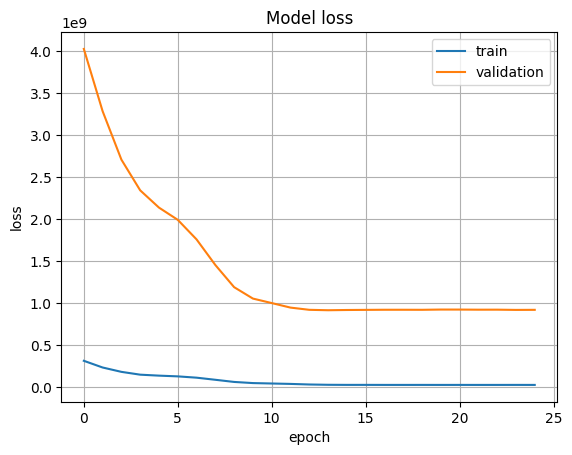

In [ ]:
# list all data in history
print(model_ann2.history.keys())
plt.plot(model_ann2.history['loss'])
plt.plot(model_ann2.history['val_loss'])
plt.grid()
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

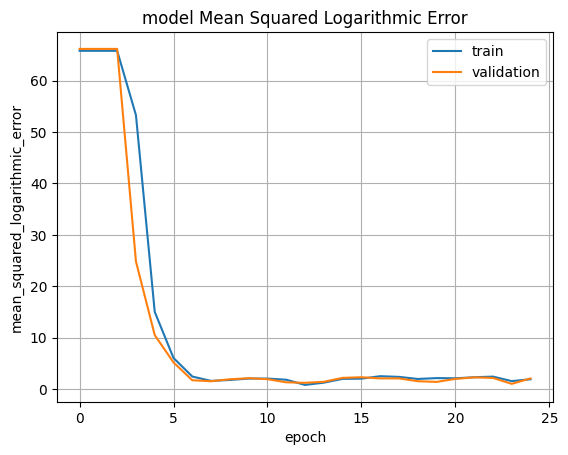

In [ ]:
# summarize history for loss
plt.plot(model_ann2.history['mean_squared_logarithmic_error'])
plt.plot(model_ann2.history['val_mean_squared_logarithmic_error'])
plt.grid()
plt.title('model Mean Squared Logarithmic Error')
plt.ylabel('mean_squared_logarithmic_error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
score3_df = pd.concat([pd.DataFrame(y_pred2),pd.DataFrame(y_val2)], axis=1)
score3_df.columns = ["validation","predict"]
score3_df

,validation,predict
0,87.879456,318
1,8546.803711,5227
2,4141.441406,2100
3,2273.870850,510
4,3578.650391,2156
...,...,...
209,2249.048096,2890
210,2606.200439,5400
211,1381.819702,1600
212,5589.744141,5100


#### Model 4_1 (Ridge, Lasso)
- 변수: 공연장소, 공연유형, 신청인원,사용일수, vector3_col

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

최적의 규제

In [ ]:
from traitlets.traitlets import validate
train_score = []
val_score = []
alpha_list = np.logspace(-4, 0, 200)
for alpha in alpha_list:
  # 파라미터를 전달하여 릿지모델을 만든다
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_train1, y_train1)
  train_score.append(ridge.score(X_train1, y_train1))
  val_score.append(ridge.score(X_val1, y_val1))

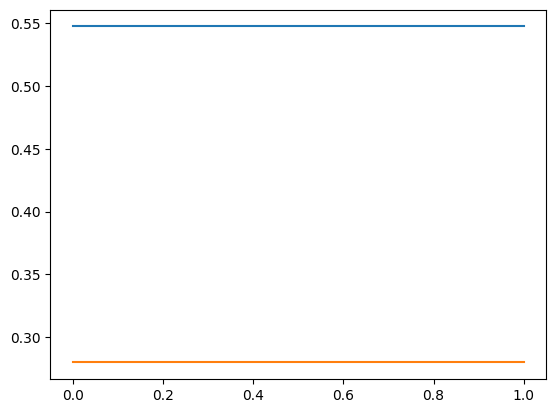

In [ ]:
plt.plot(alpha_list, train_score)
plt.plot(alpha_list, val_score)
plt.show()

In [ ]:
alpha_list[np.argmax(val_score)]

0.0001

Ridge Regression

In [ ]:
model4_ridge = Ridge(1)
model4_ridge.fit(X_train1, y_train1)
y_pred_ri = model4_ridge.predict(X_val1)

mean_squared_error(y_val1, y_pred_ri)

1266576527.7174046

In [ ]:
print("훈련 세트의 정확도 : {:.2f}".format(ridge.score(X_train1, y_train1)))
print("테스트 세트의 정확도 : {:.2f}".format(ridge.score(X_val1, y_val1)))

훈련 세트의 정확도 : 0.55
테스트 세트의 정확도 : 0.28


In [ ]:
score4_ri = pd.concat([pd.DataFrame(y_pred_ri),pd.DataFrame(y_val1)], axis=1)
score4_ri.columns = ["validation","predict"]
score4_ri

,validation,predict
0,3659.868318,150
1,3087.075315,2162
2,3638.737998,148
3,9576.274271,26545
4,3186.968881,2810
...,...,...
209,8426.521526,6760
210,6684.993815,6657
211,15776.702632,34117
212,8493.779046,7449


Lasso Regression

최적의 규제

In [ ]:
train_score = []
test_score = []
alpha_list = np.logspace(-4, 0, 200)
for alpha in alpha_list:
  # 파라미터를 전달하여 릿지모델을 만든다
  lasso = Lasso(alpha = alpha, max_iter = 10000)
  lasso.fit(X_train1, y_train1)
  train_score.append(lasso.score(X_train1, y_train1))
  test_score.append(lasso.score(X_test1, y_test1))

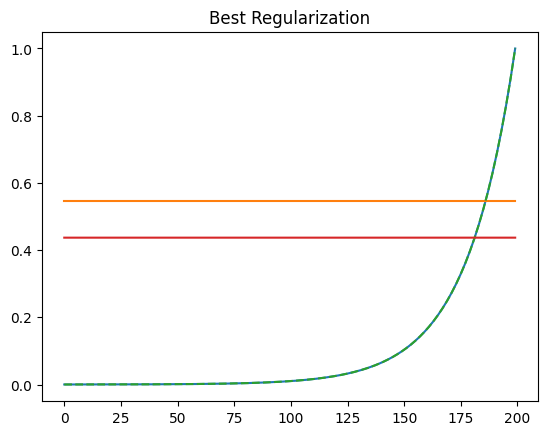

In [ ]:
plt.plot(alpha_list, '-',train_score)
plt.plot(alpha_list, '--',test_score)
plt.title("Best Regularization")
plt.show()

In [ ]:
alpha_list[np.argmax(test_score)]

1.0

In [ ]:
model4_lasso = Lasso(1)
model4_lasso.fit(X_train1, y_train1)
y_pred_la = model4_lasso.predict(X_test1)

mean_squared_error(y_test1, y_pred_la)

48149537.58338845

In [ ]:
print("훈련 세트의 정확도 : {:.2f}".format(lasso.score(X_train1, y_train1)))
print("테스트 세트의 정확도 : {:.2f}".format(lasso.score(X_val1, y_val1)))

훈련 세트의 정확도 : 0.55
테스트 세트의 정확도 : 0.28


In [ ]:
score4_la = pd.concat([pd.DataFrame(y_pred_la),pd.DataFrame(y_test1)], axis=1)
score4_la.columns = ["test","predict"]
score4_la

,test,predict
0,6850.506609,5708
1,7639.617751,5594
2,15997.763289,18135
3,13094.675244,34846
4,763.340205,500
...,...,...
263,6860.748288,5700
264,2407.945453,419
265,8036.294244,3991
266,1852.910556,5000


#### Model 4-2 (Ridge, Lasso)
- 변수: 공연장소, 신청인원, 사용일수, 휴일, END_AVG_WEEKDAY, 년도, 월, 계절, vector3_col

최적의 규제

In [ ]:
train_score = []
test_score = []
alpha_list = np.logspace(-4, 0, 200)
for alpha in alpha_list:
  # 파라미터를 전달하여 릿지모델을 만든다
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_train2, y_train2)
  train_score.append(ridge.score(X_train2, y_train2))
  test_score.append(ridge.score(X_val2, y_val2))

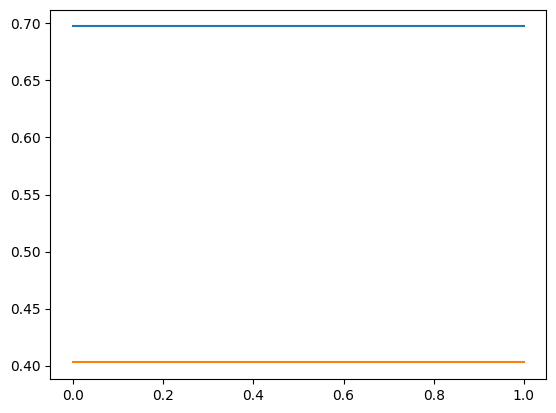

In [ ]:
plt.plot(alpha_list, train_score)
plt.plot(alpha_list, test_score)
plt.show()

In [ ]:
alpha_list[np.argmax(test_score)]

1.0

Ridge Regression

In [ ]:
model4_2_ridge = Ridge(1)
model4_2_ridge.fit(X_train2, y_train2)
y_pred_ri = model4_2_ridge.predict(X_val2)

mean_squared_error(y_val2, y_pred_ri)

1067979392.3607714

In [ ]:
print("훈련 세트의 정확도 : {:.2f}".format(ridge.score(X_train2, y_train2)))
print("테스트 세트의 정확도 : {:.2f}".format(ridge.score(X_val2, y_val2)))

훈련 세트의 정확도 : 0.70
테스트 세트의 정확도 : 0.40


In [ ]:
score4_2_ri = pd.concat([pd.DataFrame(y_pred_ri),pd.DataFrame(y_val2)], axis=1)
score4_2_ri.columns = ["validation","predict"]
score4_2_ri

,validation,predict
0,1559.904198,318
1,8839.331243,5227
2,3575.650257,2100
3,4471.812009,510
4,4238.547036,2156
...,...,...
209,2674.512131,2890
210,3137.517653,5400
211,2212.818958,1600
212,6678.720734,5100


Lasso Regression

최적의 규제

In [ ]:
train_score = []
test_score = []
alpha_list = np.logspace(-4, 0, 200)
for alpha in alpha_list:
  # 파라미터를 전달하여 릿지모델을 만든다
  lasso = Lasso(alpha = alpha, max_iter = 10000)
  lasso.fit(X_train2, y_train2)
  train_score.append(lasso.score(X_train2, y_train2))
  test_score.append(lasso.score(X_test2, y_test2))

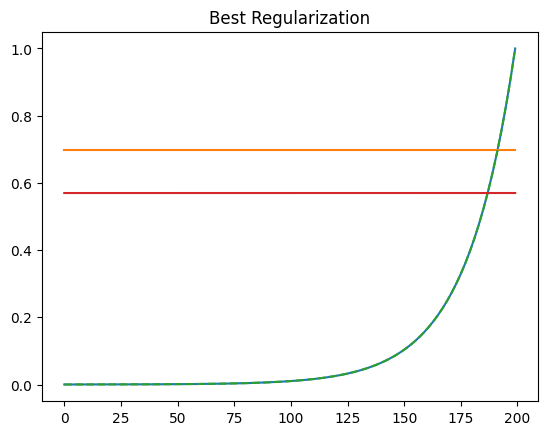

In [ ]:
plt.plot(alpha_list, '-',train_score)
plt.plot(alpha_list, '--',test_score)
plt.title("Best Regularization")
plt.show()

In [ ]:
alpha_list[np.argmax(test_score)]

1.0

In [ ]:
model4_2_lasso = Lasso(1)
model4_2_lasso.fit(X_train2, y_train2)
y_pred_la = model4_2_lasso.predict(X_val2)

mean_squared_error(y_val2, y_pred_la)

1067963397.6350408

In [ ]:
print("훈련 세트의 정확도 : {:.2f}".format(lasso.score(X_train2, y_train2)))
print("테스트 세트의 정확도 : {:.2f}".format(lasso.score(X_val2, y_val2)))

훈련 세트의 정확도 : 0.70
테스트 세트의 정확도 : 0.40


In [ ]:
score4_2_la = pd.concat([pd.DataFrame(y_pred_la),pd.DataFrame(y_val2)], axis=1)
score4_2_la.columns = ["validation","predict"]
score4_2_la

,validation,predict
0,1556.843031,318
1,8836.460542,5227
2,3575.624319,2100
3,4472.204588,510
4,4237.297772,2156
...,...,...
209,2673.926033,2890
210,3136.319475,5400
211,2212.110443,1600
212,6677.387227,5100


### Model 5_1 (결정 트리)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

In [ ]:
tree_regressor = DecisionTreeRegressor(max_depth=5)  # 원하는 최대 깊이 설정

# 모델을 훈련 데이터에 맞춥니다.
tree_regressor.fit(X_train1, y_train1)

# 테스트 데이터에 대한 예측
y_pred1 = tree_regressor.predict(X_val1)

In [ ]:
np.set_printoptions(precision=2)
print(np.concatenate((y_pred1.reshape(len(y_pred1),1), y_val1.reshape(len(y_val1),1)),1))

[[6.22e+02 1.50e+02]
 [2.13e+03 2.16e+03]
 [6.22e+02 1.48e+02]
 [1.53e+04 2.65e+04]
 [3.26e+03 2.81e+03]
 [2.57e+04 2.57e+04]
 [2.57e+04 3.60e+04]
 [6.22e+02 1.35e+02]
 [6.22e+02 8.00e+02]
 [3.26e+03 3.77e+03]
 [6.22e+02 1.00e+02]
 [1.25e+04 1.19e+04]
 [1.86e+04 1.28e+04]
 [6.22e+02 2.56e+02]
 [6.22e+02 3.00e+02]
 [6.22e+02 9.50e+01]
 [6.18e+03 8.98e+03]
 [6.22e+02 2.06e+02]
 [2.13e+03 1.05e+03]
 [4.77e+03 4.59e+03]
 [6.22e+02 1.80e+03]
 [2.13e+03 8.90e+02]
 [1.86e+04 1.96e+04]
 [6.22e+02 2.35e+02]
 [2.13e+03 1.00e+03]
 [4.54e+04 4.25e+04]
 [2.13e+03 1.80e+03]
 [1.53e+04 4.79e+03]
 [4.77e+03 3.00e+03]
 [2.13e+03 4.44e+03]
 [6.18e+03 3.72e+03]
 [6.22e+02 7.00e+01]
 [6.22e+02 2.35e+02]
 [1.25e+04 1.54e+04]
 [6.22e+02 2.06e+03]
 [4.77e+03 4.09e+03]
 [6.22e+02 8.70e+02]
 [3.26e+03 3.96e+03]
 [3.26e+03 1.61e+03]
 [1.02e+04 4.35e+03]
 [2.13e+03 1.00e+03]
 [2.13e+03 2.55e+03]
 [4.77e+03 2.44e+03]
 [6.22e+02 2.00e+02]
 [4.77e+03 2.69e+03]
 [6.22e+02 2.00e+03]
 [2.65e+03 2.00e+02]
 [2.13e+03 2.

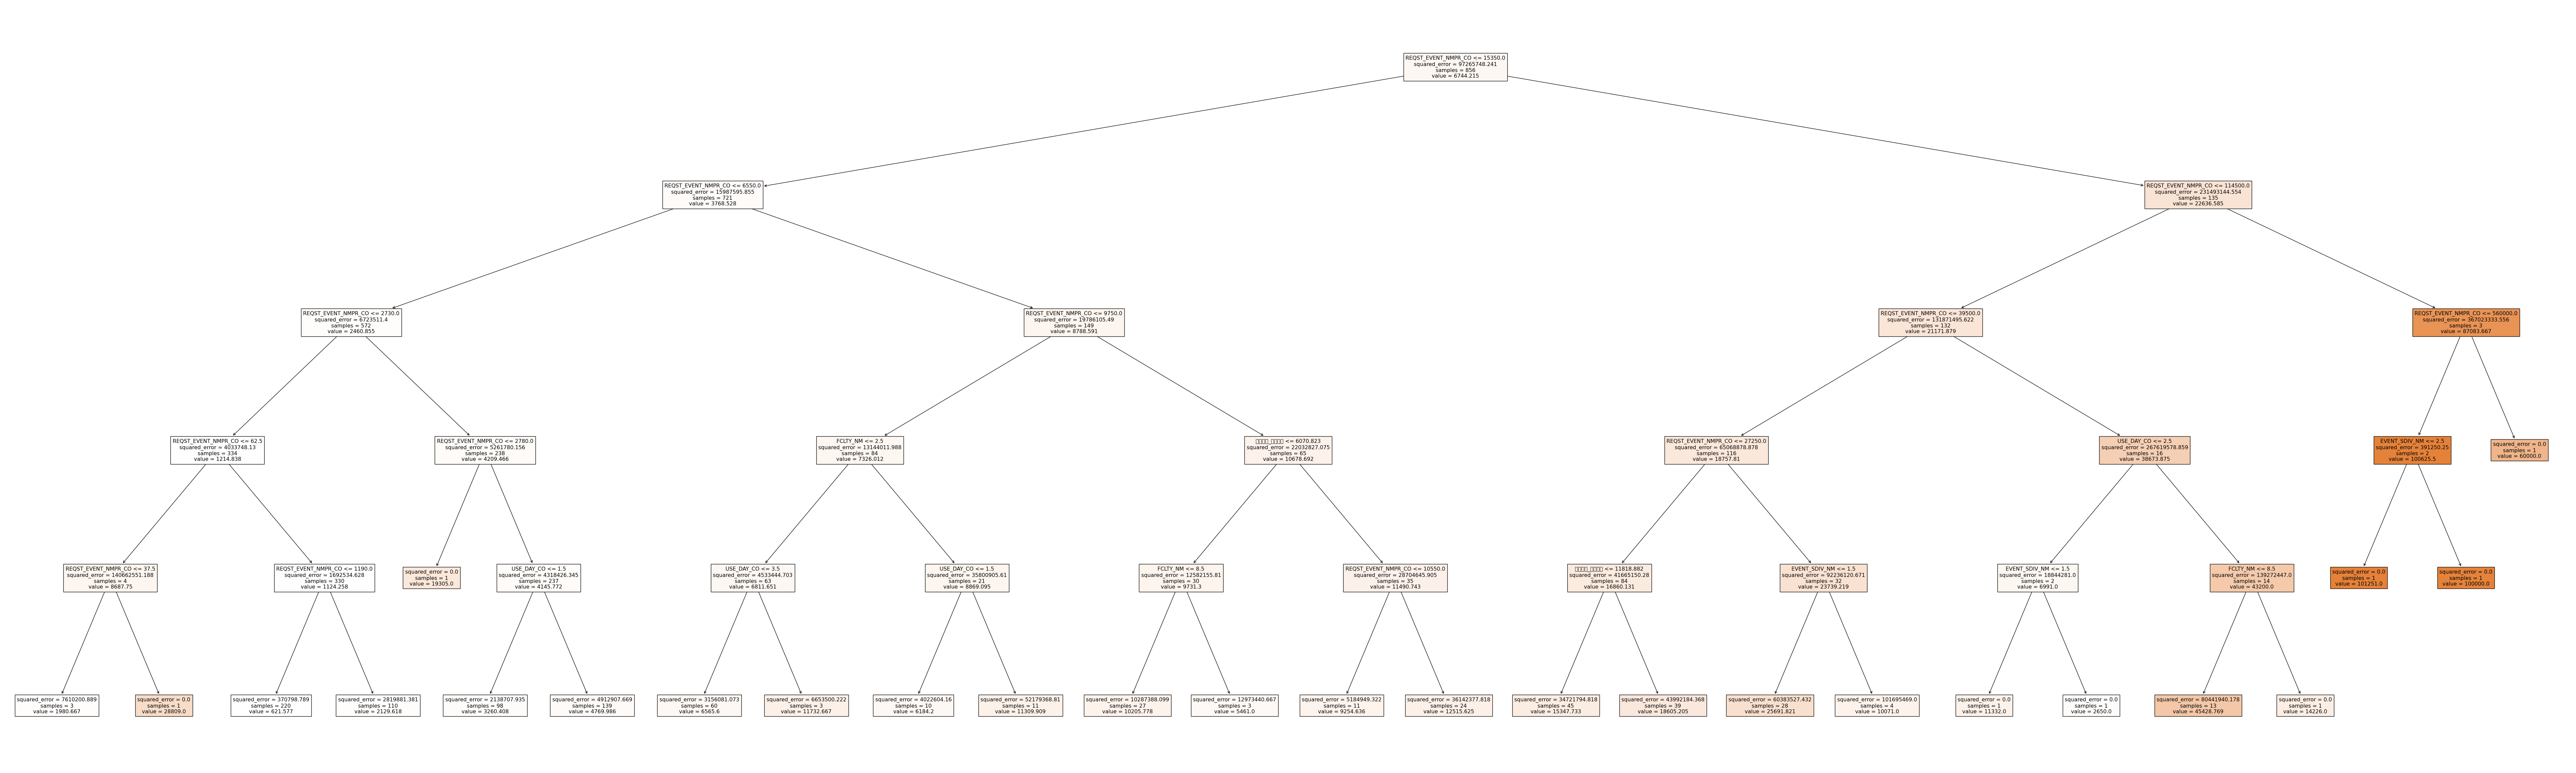

In [ ]:
# 의사 결정 나무 모델 시각화
plt.figure(figsize=(100, 30))
plot_tree(tree_regressor, filled=True, feature_names=df_train1.columns)  # X.columns는 특성의 이름 목록입니다.
plt.show()

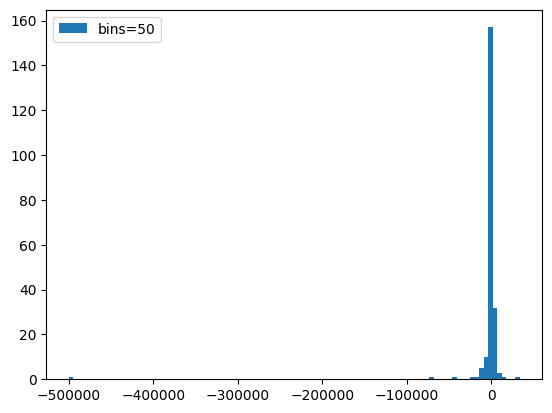

In [ ]:
residual = y_pred1 - y_val1
plt.hist(residual, bins=100, label='bins=50')
plt.legend()
plt.show()

In [ ]:
# 모델의 성능 평가 (예: 평균 제곱 오차)
mse = mean_squared_error(y_val1, y_pred1)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1427335247.0177977


### Model 5_2 (결정 트리)

In [ ]:
tree_regressor = DecisionTreeRegressor(max_depth=5)  # 원하는 최대 깊이 설정

# 모델을 훈련 데이터에 맞춥니다.
tree_regressor.fit(X_train2, y_train2)

# 테스트 데이터에 대한 예측
y_pred2 = tree_regressor.predict(X_val2)

In [ ]:
np.set_printoptions(precision=2)
print(np.concatenate((y_pred2.reshape(len(y_pred2),1), y_val2.reshape(len(y_val2),1)),1))

[[5.78e+02 3.18e+02]
 [6.18e+03 5.23e+03]
 [4.31e+03 2.10e+03]
 [5.78e+02 5.10e+02]
 [4.31e+03 2.16e+03]
 [1.65e+03 9.92e+02]
 [4.31e+03 6.66e+03]
 [5.78e+02 1.00e+02]
 [1.26e+04 1.25e+04]
 [5.78e+02 6.00e+02]
 [1.65e+03 2.00e+03]
 [4.31e+03 4.78e+03]
 [1.81e+04 1.63e+04]
 [4.31e+03 2.66e+03]
 [1.65e+03 2.19e+03]
 [4.31e+03 5.00e+03]
 [4.08e+03 4.85e+03]
 [2.36e+03 2.31e+03]
 [1.08e+04 5.56e+03]
 [5.78e+02 1.28e+02]
 [5.78e+02 1.93e+02]
 [1.34e+04 6.19e+03]
 [1.65e+03 2.00e+03]
 [1.34e+04 1.04e+04]
 [1.81e+04 2.00e+03]
 [8.66e+03 5.00e+03]
 [1.94e+04 2.12e+04]
 [1.65e+03 2.00e+03]
 [1.34e+04 9.65e+03]
 [2.88e+04 2.82e+04]
 [1.65e+03 1.00e+03]
 [8.66e+03 1.28e+04]
 [1.65e+03 8.90e+02]
 [4.31e+03 3.30e+03]
 [2.36e+03 1.92e+03]
 [4.31e+03 4.01e+03]
 [4.08e+03 1.25e+03]
 [2.36e+03 1.89e+03]
 [1.65e+03 7.90e+02]
 [1.94e+04 1.85e+04]
 [2.36e+03 2.00e+03]
 [6.18e+03 1.50e+04]
 [2.88e+04 2.68e+04]
 [4.31e+03 4.99e+03]
 [8.66e+03 7.00e+03]
 [2.36e+03 1.05e+03]
 [1.08e+04 1.10e+04]
 [5.78e+02 4.

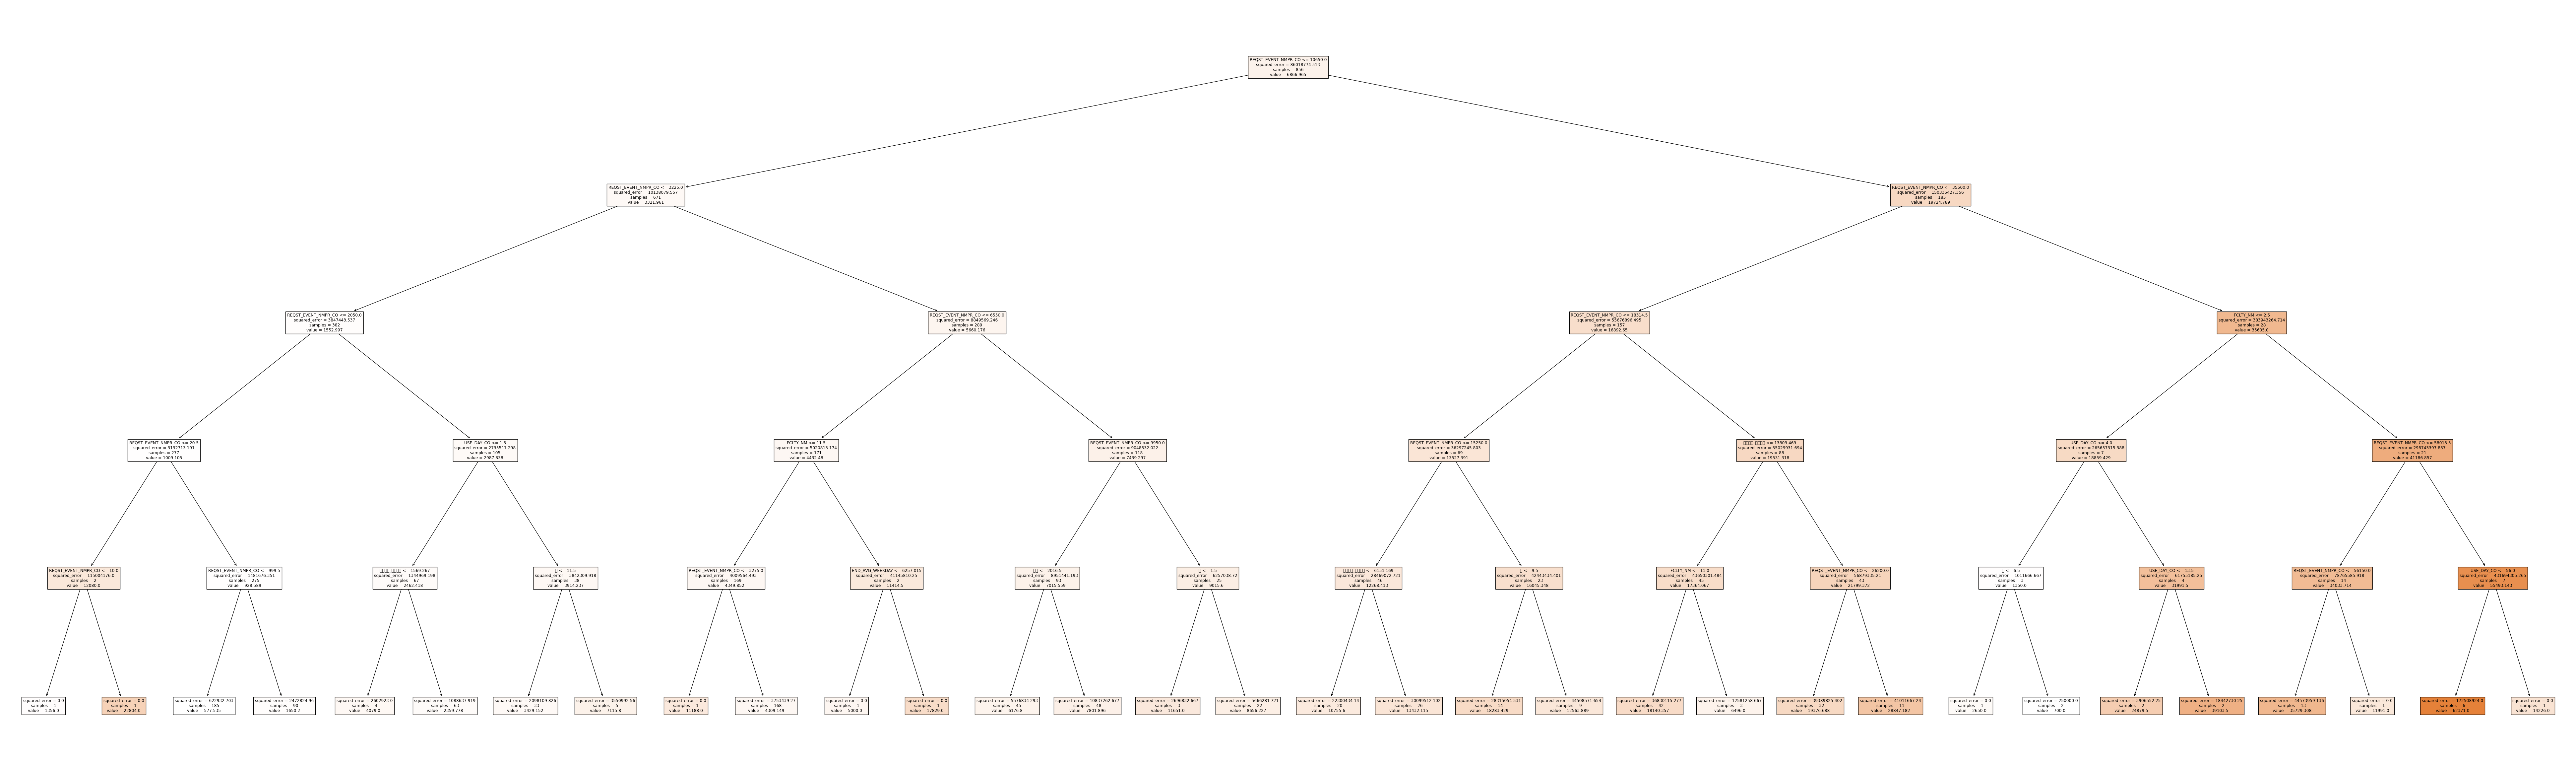

In [ ]:
# 의사 결정 나무 모델 시각화
plt.figure(figsize=(100, 30))
plot_tree(tree_regressor, filled=True, feature_names=df_train2.columns)  # X.columns는 특성의 이름 목록입니다.
plt.show()

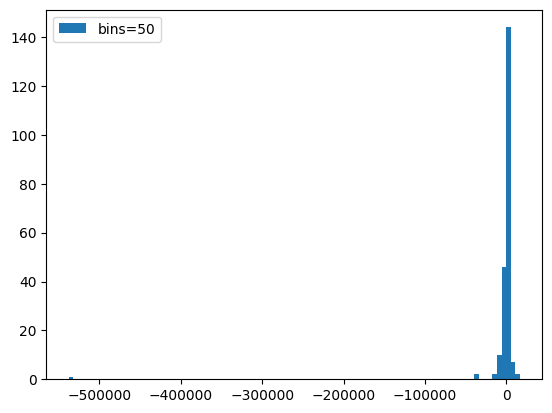

In [ ]:
residual = y_pred2 - y_val2
plt.hist(residual, bins=100, label='bins=50')
plt.legend()
plt.show()

In [ ]:
# 모델의 성능 평가 (예: 평균 제곱 오차)
mse = mean_squared_error(y_val2, y_pred2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1375140443.1232684


#### 성능지표

 인터뷰 "예측인원이 실제 인원의 10% 오차 범위에 있다면 사용할 것 같다"에 기반하여 지표 생성하고자 함.

(1) 선형회귀모델
(2) ANN 모델
: 몇 퍼센트의 성공률을 보이는지

In [ ]:
# model1(평균)의 mse:
# model2(회귀분석)의 mse: 122745224.87898044
# model2_2(회귀분석)의 mse: 119739947.99359883
# model3(ANN)의 mse:21956005.58449393
# model4(Ridge)의 mse:
# model4(Lasso)의 mse:

오차범위계산 함수 (예측 인원이 실제 인원의 10% 오차 범위에 있는지 여부)

In [ ]:
def Error_fun(df,real, predict):
  df["pre_success"] = (df[predict] >= df[real]*0.9) & (df[predict] <= df[real]*1.1)
  return len(df.loc[df["pre_success"] == True])/len(df) # 예측 퍼센트 도출

In [ ]:
Error_fun(score2_df,"EXCCLC_EVENT_NMPR_CO","makeprediction2")

0.1397608370702541

In [ ]:
Error_fun(score2_2_df,"EXCCLC_EVENT_NMPR_CO","makeprediction2")

0.1031390134529148

In [ ]:
Error_fun(score3_df,"test","predict")

0.1791044776119403

In [ ]:
Error_fun(score4_la,"test","predict")

0.10820895522388059

In [ ]:
Error_fun(score4_ri,"test","predict")

0.10820895522388059

In [ ]:
Error_fun(score4_2_la,"test","predict")

0.06716417910447761

In [ ]:
Error_fun(score4_2_ri,"test","predict")

0.06716417910447761